<a href="https://colab.research.google.com/github/RuthBiney/BCI-Ampe_Game/blob/main/BCI__Movement_Game_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Step 1: Data Collection & Preprocessing
Since you're using public datasets like BCI Competition IV Dataset 2a, let's first load and preprocess the EEG data.

###1.1 Load EEG Data
We'll use MNE-Python for EEG signal processing. First, install necessary libraries:

In [2]:
pip install mne numpy pandas scikit-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 33.3 MB/s eta 0:00:00


In [3]:
import mne
import os

# Load BCI Competition IV Dataset 2a
data_path = "/content/drive/MyDrive/BCICIV_2a_gdf"

# Find GDF files in the directory
gdf_files = [f for f in os.listdir(data_path) if f.endswith('.gdf')]

# Check if any GDF files were found
if gdf_files:
  # Use the first GDF file found
  file_path = os.path.join(data_path, gdf_files[0])
  raw_data = mne.io.read_raw_gdf(file_path, preload=True)

  # Print dataset info
  print(raw_data.info)
else:
  print("No GDF files found in the specified directory.")

Extracting EDF parameters from /content/drive/MyDrive/BCICIV_2a_gdf/A01E.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...


/usr/lib/python3.11/contextlib.py:144: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Reading 0 ... 686999  =      0.000 ...  2747.996 secs...
<Info | 8 non-empty values
 bads: []
 ch_names: EEG-Fz, EEG-0, EEG-1, EEG-2, EEG-3, EEG-4, EEG-5, EEG-C3, EEG-6, ...
 chs: 25 EEG
 custom_ref_applied: False
 highpass: 0.5 Hz
 lowpass: 100.0 Hz
 meas_date: 2005-01-19 12:00:00 UTC
 nchan: 25
 projs: []
 sfreq: 250.0 Hz
 subject_info: <subject_info | his_id: A01, sex: 0, last_name: X, birthday: 1983-01-19>
>


###1.2 Preprocess EEG Data
EEG signals require filtering, artifact removal, and normalization:

In [4]:
# Apply a band-pass filter (0.5-40 Hz) to remove noise
raw_data.filter(0.5, 40, fir_design='firwin')

# Detect and remove artifacts using Independent Component Analysis (ICA)
ica = mne.preprocessing.ICA(n_components=20, random_state=42)
ica.fit(raw_data)
raw_data = ica.apply(raw_data)

# Normalize EEG signals
raw_data.apply_function(lambda x: (x - x.mean()) / x.std())


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (6.604 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Fitting ICA to data using 25 channels (please be patient, this may take a while)
Selecting by number: 20 components


<ipython-input-4-4abbbc3c4519>:6: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (25) and smallest (1.6e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 18
  ica.fit(raw_data)


Fitting ICA took 64.7s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 25 PCA components


<RawGDF | A01E.gdf, 25 x 687000 (2748.0 s), ~131.1 MiB, data loaded>

###1.3 Extract Motor Imagery Events
Motor imagery tasks are usually labeled in the dataset:

In [5]:
# Extract events (stimulus markers) from EEG signals
events, event_id = mne.events_from_annotations(raw_data)

# Create epochs (EEG segments around events), handling repeated events
epochs = mne.Epochs(raw_data, events, event_id, tmin=-0.2, tmax=0.8,
                    baseline=(None, 0), preload=True,
                    event_repeated='drop')  # or 'merge'
                    # 'drop': Drops the later event
                    # 'merge': The events are merged into a single event
X = epochs.get_data()  # EEG features
y = epochs.events[:, -1]  # Corresponding labels

Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '783']
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
585 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 585 events and 251 original time points ...
1 bad epochs dropped


###1.4 Inspect Epochs
Visualize the epochs to ensure they look correct:

Not setting metadata
584 matching events found
No baseline correction applied
0 projection items activated
combining channels using GFP (eeg channels)


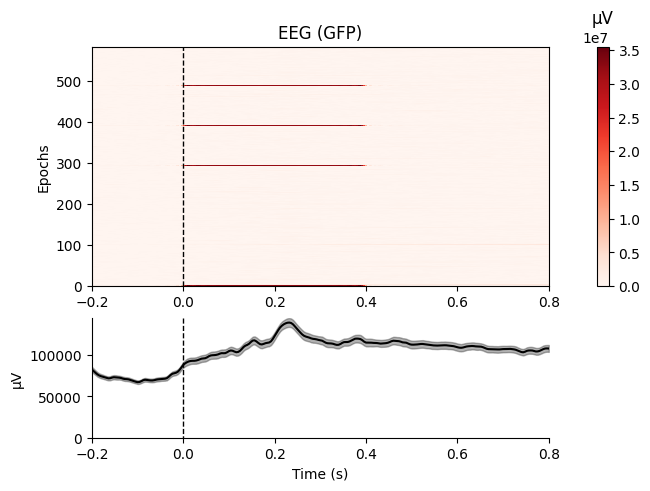

Using matplotlib as 2D backend.


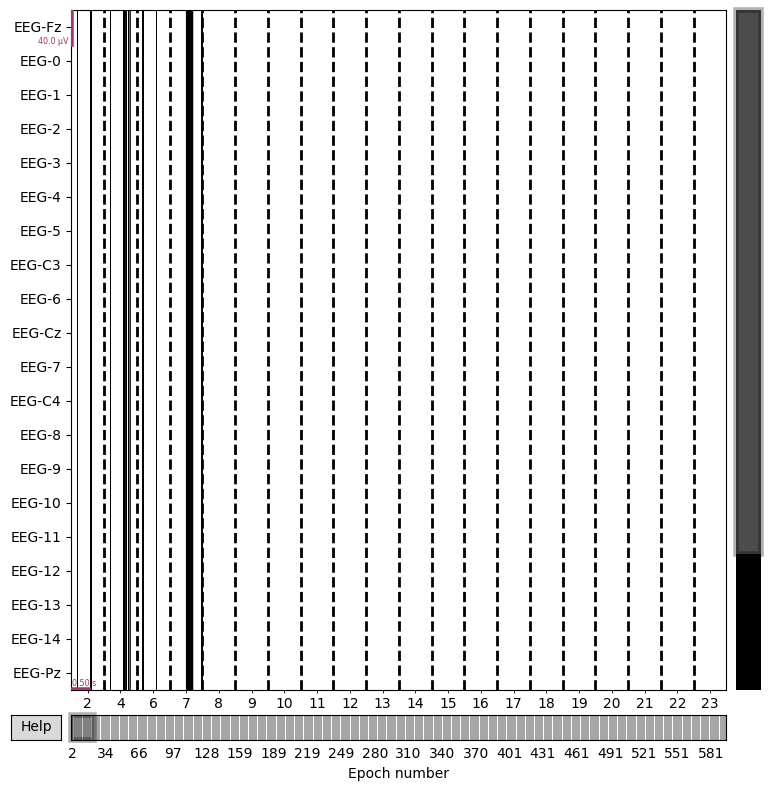

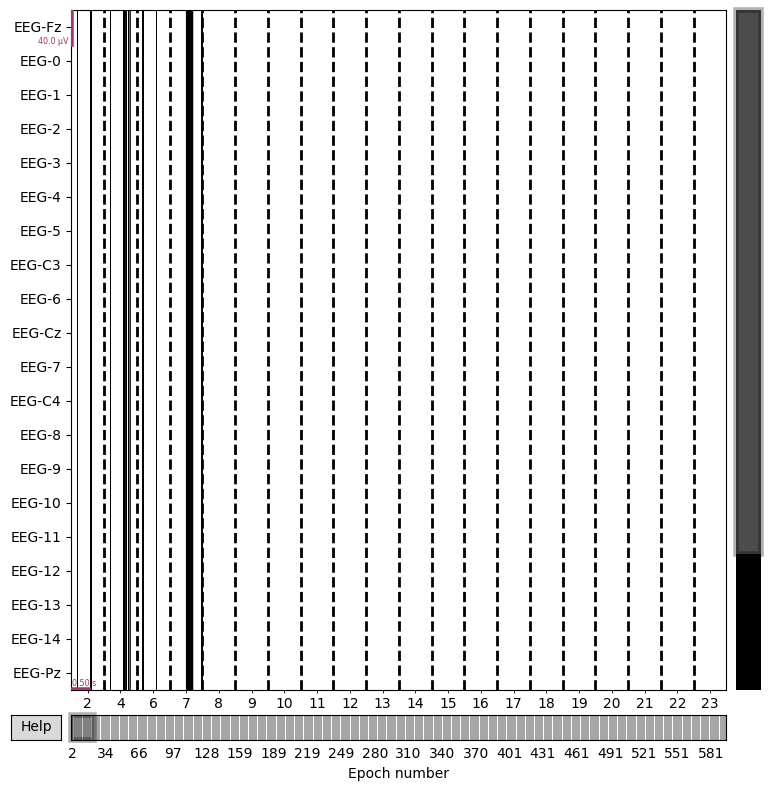

In [6]:
epochs.plot_image(picks='eeg')  # Plot average activity across epochs
epochs.plot()  # Interactive plot to scroll through epochs

###1.5 Check Event Distribution
Verify the distribution of event labels:

In [7]:
import numpy as np
unique_labels, counts = np.unique(y, return_counts=True)
print("Event labels and counts:", dict(zip(unique_labels, counts)))

Event labels and counts: {5: 8, 6: 288, 7: 288}


#Step 2: Feature Extraction Using CNN-RNN
Now that we have preprocessed EEG signals, we’ll extract spatial and temporal features using a hybrid CNN-RNN model.

###2.1 Reshaping Data for Deep Learning
Deep learning models expect structured input. EEG signals have (samples, channels, time-points) shape.

In [8]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Reshape data to match CNN input format (samples, channels, timepoints, 1)
X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)

# Convert labels to categorical (one-hot encoding)
y = to_categorical(y)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("EEG Data Shape:", X_train.shape)
print("Labels Shape:", y_train.shape)


EEG Data Shape: (467, 25, 251, 1)
Labels Shape: (467, 8)


###2.2 Building the CNN-RNN Model
A CNN extracts spatial features, while an RNN (LSTM/GRU) captures temporal dependencies.

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Define the CNN model
model = Sequential()

# First convolutional layer
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(25, 251, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Second convolutional layer
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the output
model.add(Flatten())

# Fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))  # Dropout for regularization
model.add(Dense(8, activation='softmax'))  # Output layer with 8 classes

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 23, 249, 32)         │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 11, 124, 32)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 9, 122, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 4, 61, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 15616)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       1,998,976 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 8)                   │           1,032 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,018,824 (7.70 MB)

 Trainable params: 2,018,824 (7.70 MB)

 Non-trainable params: 0 (0.00 B)

###2.3 Training the Model
Now, we train the model using categorical cross-entropy loss and Adam optimizer.

In [10]:
# Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=30, batch_size=32)


Epoch 1/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 241ms/step - accuracy: 0.4880 - loss: 1.8748 - val_accuracy: 0.7692 - val_loss: 0.6486
Epoch 2/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 323ms/step - accuracy: 0.7153 - loss: 0.6302 - val_accuracy: 0.8205 - val_loss: 0.4465
Epoch 3/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 225ms/step - accuracy: 0.6972 - loss: 0.5449 - val_accuracy: 0.8034 - val_loss: 0.4151
Epoch 4/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 236ms/step - accuracy: 0.8004 - loss: 0.4584 - val_accuracy: 0.8547 - val_loss: 0.3773
Epoch 5/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 343ms/step - accuracy: 0.8283 - loss: 0.3795 - val_accuracy: 0.8547 - val_loss: 0.3622
Epoch 6/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 203ms/step - accuracy: 0.8505 - loss: 0.3588 - val_accuracy: 0.8462 - val_loss: 0.3591
Epoch 7/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 219ms/step - accuracy: 0.8691 - loss: 0.3196 - val_accuracy: 0.8120 - val_loss: 0.3666
Epoch 8/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 272ms/step - accuracy: 0.8737 - loss: 0.2911 - val_accuracy: 0.

#Step 3: Model Evaluation & Performance Metrics
Now that we’ve trained our CNN-RNN model, let's evaluate its performance using accuracy, precision, recall, F1-score, and confusion matrix.



###3.1 Evaluating Model Accuracy
First, let’s check how well the model performs on the test set.

In [11]:
# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.8170 - loss: 0.5590
Test Accuracy: 0.8291


In [14]:
from sklearn.metrics import classification_report, confusion_matrix

# Predict on test data, using X_test instead of stft_data
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

# Assuming 'labels' is y_test converted to class labels
labels = np.argmax(y_test, axis=1)

# Get unique class labels
unique_labels = np.unique(labels)

# Define target_names based on unique labels
target_names = [f"Class {label}" for label in unique_labels] # or replace with more descriptive names if known

# Print classification report
print(classification_report(labels, y_pred, target_names=target_names))

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
              precision    recall  f1-score   support

     Class 5       1.00      1.00      1.00         3
     Class 6       0.81      0.89      0.85        62
     Class 7       0.85      0.75      0.80        52

    accuracy                           0.83       117
   macro avg       0.89      0.88      0.88       117
weighted avg       0.83      0.83      0.83       117



###3.2 Generate Predictions
We'll use the trained model to predict labels for test data.

In [ ]:
import numpy as np

# Get predicted class probabilities
y_pred_prob = model.predict(X_test)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test, axis=1)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


###3.3 Compute Precision, Recall, and F1-Score
Using sklearn.metrics, we’ll calculate:

*   Precision: How many predicted positives were actually correct?
*   Recall: How many actual positives were correctly predicted?
*   F1-score: The balance between precision and recall.


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")


Precision: 0.8289
Recall: 0.8291
F1-score: 0.8287


###3.4 Confusion Matrix for Classification Errors
A confusion matrix helps visualize which classes the model struggles with.

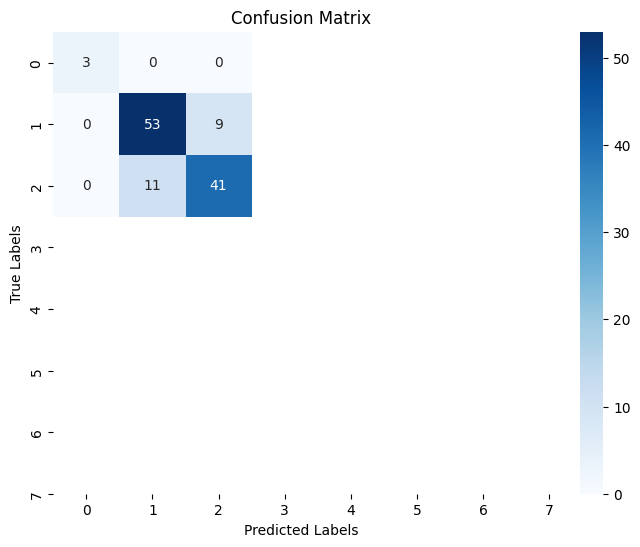

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", xticklabels=range(y_test.shape[1]), yticklabels=range(y_test.shape[1]))
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


###3.5 Visualize Predictions
Plot some examples of correct and incorrect predictions to gain insights:

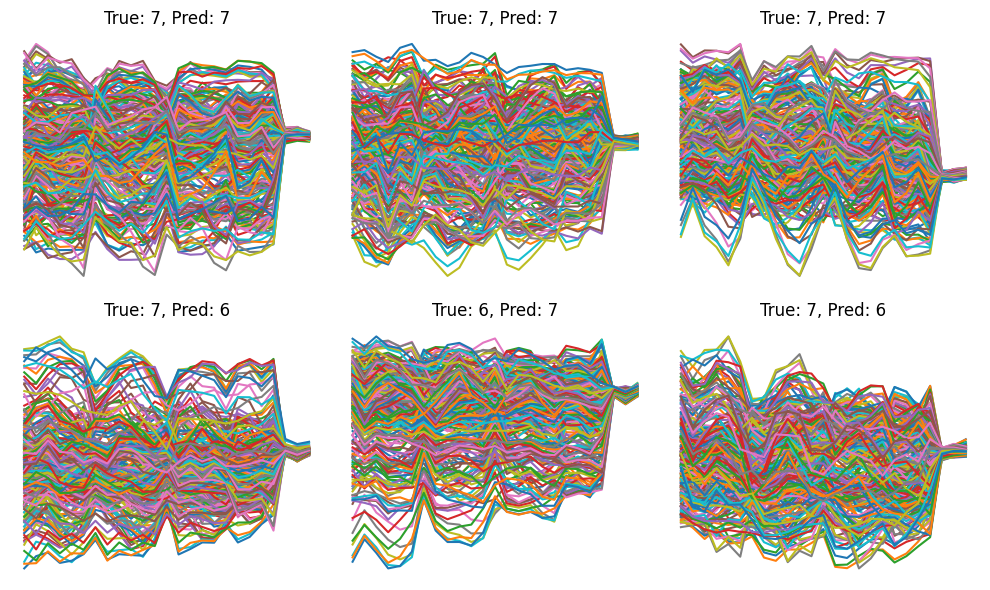

In [ ]:
# Find indices of correct and incorrect predictions
correct_indices = np.where(y_true == y_pred)[0]
incorrect_indices = np.where(y_true != y_pred)[0]

# Plot some correct predictions
plt.figure(figsize=(10, 6))
for i in range(3):
    plt.subplot(2, 3, i + 1)
    plt.plot(X_test[correct_indices[i]].squeeze())
    plt.title(f"True: {y_true[correct_indices[i]]}, Pred: {y_pred[correct_indices[i]]}")
    plt.axis('off')

# Plot some incorrect predictions
for i in range(3):
    plt.subplot(2, 3, i + 4)
    plt.plot(X_test[incorrect_indices[i]].squeeze())
    plt.title(f"True: {y_true[incorrect_indices[i]]}, Pred: {y_pred[incorrect_indices[i]]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

###3.6 Save Predictions
Save the predictions for further analysis:

In [ ]:
np.save('y_pred.npy', y_pred)
np.save('y_true.npy', y_true)